# Notebook for Combining Models
## Upload Necessary Files for Code to Run

In [ ]:
# 1: Import necessary libraries
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio
import numpy as np
import os
from torch.utils.data import Dataset, dataloader
import os

In [ ]:
# 2. Upload wav for Whisper word translation and speech emotion detection
from google.colab import files
print("Upload the wav file for emotion extraction")
uploaded = files.upload()
audio_path = list(uploaded.keys())[0]

# 3. Upload image file for emotion detection
print("Upload the JPG file for emotion extraction")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# 4. Define basic environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emotional_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

Upload the wav file for emotion extraction


Saving WalterWhite.wav to WalterWhite (1).wav
Upload the JPG file for emotion extraction


Saving WW_IATOWK.jpg to WW_IATOWK (1).jpg


In [ ]:
# 6. Upload trained image model checkpoint .pt file
print("Upload the .pt file for the trained image model")
uploaded = files.upload()
model3_path = list(uploaded.keys())[0]

Upload the .pt file for the trained image model


Saving emotion_cnn_model.pt to emotion_cnn_model.pt


## Model 1 - Whisper Model

In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# Load Whisper Tiny
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")

# Audio translation function
def transcribe_audio_whisper(audio_path, model, processor, device):
    # Ensure model is on the right device
    model = model.to(device)
    model.eval()

    # 1. Load
    waveform, sr = torchaudio.load(audio_path)

    # 2. Resample if needed
    if sr != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(waveform)

    # 3. Stereo → mono
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # 4. Convert to numpy
    waveform = waveform.squeeze().numpy()

    # 5. Extract features & move to device
    inputs = processor.feature_extractor(
        waveform,
        sampling_rate=16000,
        return_tensors="pt"
    ).input_features.to(device)  # now matches model's device

    # 6. Generate & decode
    with torch.no_grad():
        predicted_ids = model.generate(inputs)
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    return transcription

In [ ]:
transcription = transcribe_audio_whisper(
    audio_path,
    model,
    processor,
    device
)
print("Transcription:", transcription)

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Transcription:  You clearly don't know who you're talking to. So let me clue you in. I am not in danger, Skyler. I am the danger. A guy opens his door and gets shot and you think of that of me. Now I am the one who knocks.


In [ ]:
from transformers import pipeline

def predict_text_emotion(transcription):
    # Run Hugging Face pipeline
    classifier = pipeline(
        "text-classification",
        model="j-hartmann/emotion-english-roberta-large",
        return_all_scores=True,
        top_k=None
    )
    results = classifier(transcription)[0]

    # Map HF labels to standardized labels
    label_map = {
        "anger":     "angry",
        "disgust":   "disgusted",
        "fear":      "fearful",
        "joy":       "happy",
        "neutral":   "neutral",
        "sadness":   "sad",
        "surprise":  "surprised"
    }

    # Build raw and standardized probability dict
    raw_dict = {entry['label'].lower(): entry['score'] for entry in results}
    prob_dict = {label: raw_dict.get(hf_label, 0.0) for hf_label, label in label_map.items()}

    # Ensure all emotional_labels are present
    for label in emotional_labels:
        prob_dict.setdefault(label, 0.0)

    # Create figure without auto-showing it
    fig, ax = plt.subplots(figsize=(8, 4))
    values = [prob_dict[label] for label in emotional_labels]
    ax.bar(emotional_labels, values, color='skyblue')
    ax.set_title("Text Emotion Softmax Prediction")
    ax.set_ylabel("Probability")
    ax.set_ylim(0, 1)

    # Explicitly set ticks before setting labels
    ax.set_xticks(range(len(emotional_labels)))
    ax.set_xticklabels(emotional_labels, rotation=45)

    ax.grid(axis='y')
    plt.tight_layout()

    return {
        'probabilities': prob_dict,
        'fig': fig
    }

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


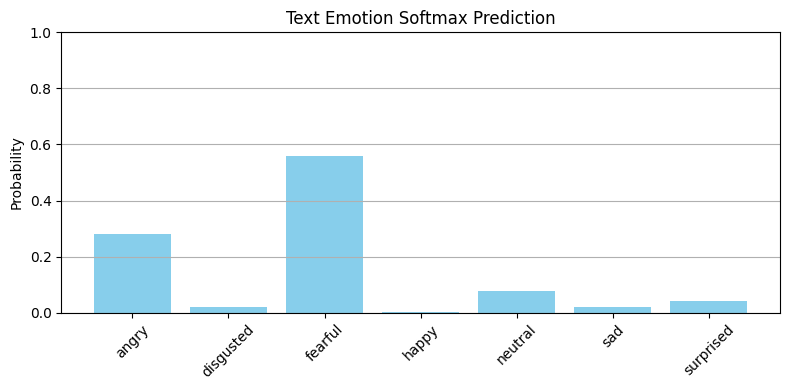

In [ ]:
result     = predict_text_emotion(transcription)
text_probs = result['probabilities']
text_fig   = result['fig']
text_array = np.array([ text_probs[label] for label in emotional_labels ])

## Model 2 - Audio Detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# initialise the processor and model
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

processor = Wav2Vec2Processor.from_pretrained('patrickvonplaten/wav2vec2-base')
model = Wav2Vec2ForSequenceClassification.from_pretrained('patrickvonplaten/wav2vec2-base', num_labels=7)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.89k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at patrickvonplaten/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def load_checkpoint(model):
    try:
        # Determine available device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load with proper device mapping
        checkpoint = torch.load('/content/drive/MyDrive/checkpoint.pth',
                               map_location=device,
                               weights_only=True)

        print("✓ Checkpoint loaded successfully")
        print(f"Training progress: epoch {checkpoint['epoch']}, step {checkpoint['global_step']}")

        # Load model state and move to proper device
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)

    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        return None

# After your model initialisation
model = Wav2Vec2ForSequenceClassification.from_pretrained('patrickvonplaten/wav2vec2-base', num_labels=7)

# Load checkpoint
loaded = load_checkpoint(model)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at patrickvonplaten/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

✓ Checkpoint loaded successfully
Training progress: epoch 3.0, step 420


In [ ]:
def preprocess_audio(file_path):
    # Load audio file
    waveform, sample_rate = torchaudio.load(file_path)

    # Resample to 16kHz if needed (Wav2Vec2 expects 16kHz)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(sample_rate, 16000)
        waveform = resampler(waveform)

    # Convert to mono if stereo
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Normalize audio
    waveform = waveform / torch.max(torch.abs(waveform))

    return waveform.squeeze().numpy()  # Return as numpy array

def predict_voice_emotion(file_path):
    # Ensure model is in eval mode
    model.eval()

    # Preprocess audio
    audio_array = preprocess_audio(file_path)

    # HF‐style label mapping → your standard labels
    label_map = {
        "anger":     "angry",
        "disgust":   "disgusted",
        "fear":      "fearful",
        "joy":       "happy",
        "neutral":   "neutral",
        "sadness":   "sad",
        "surprise":  "surprised"
    }

    # Tokenize / featurize
    inputs = processor(
        audio_array,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    ).to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    # Build probability dict
    # assume the model’s .config.id2label gives HF labels in order
    hf_labels = [model.config.id2label[i] for i in range(len(probs))]
    prob_dict   = { emotional_labels[i]: float(probs[i]) for i in range(len(probs)) }

    # Make bar‐plot
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(emotional_labels, probs, color='skyblue')
    ax.set_title("Audio Emotion Softmax Prediction")
    ax.set_ylabel("Probability")
    ax.set_ylim(0, 1)
    ax.set_xticklabels(emotional_labels, rotation=45, ha='right')
    ax.grid(axis='y')
    plt.tight_layout()

    return prob_dict, fig

<ipython-input-18-dd38a09c592f>:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(emotional_labels, rotation=45, ha='right')


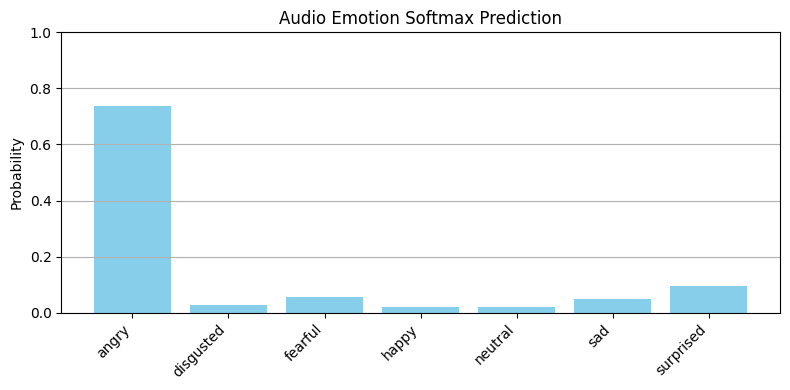

In [ ]:
voice_probs, voice_fig = predict_voice_emotion(audio_path)
voice_array = np.array([ voice_probs[label] for label in emotional_labels ])

## Model 3 Image Emotion

Model Architecture

In [ ]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 7)  # 7 emotion classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [ ]:
model = EmotionCNN().to(device)
model.load_state_dict(torch.load(model3_path, map_location=device))
model.eval()

EmotionCNN(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),  # Match training size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
def predict_image_emotion(image_path):
    image = Image.open(image_path).convert("L")  # Grayscale
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(image)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    # Map probabilities to labels
    prob_dict = {emotional_labels[i]: float(probs[i]) for i in range(len(emotional_labels))}

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(emotional_labels, probs, color='skyblue')
    ax.set_title("Image Emotion Softmax Prediction")
    ax.set_ylabel("Probability")
    ax.set_ylim(0, 1)
    ax.set_xticklabels(emotional_labels, rotation=45)
    ax.grid(axis='y')
    plt.tight_layout()

    return prob_dict, fig

<ipython-input-23-849dcd0f28f6>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(emotional_labels, rotation=45)


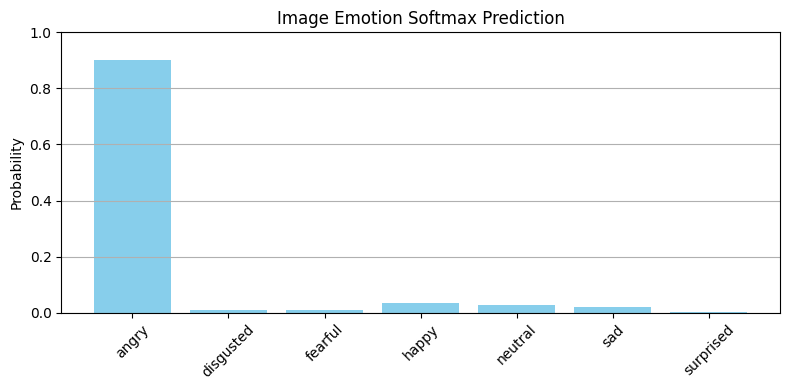

In [ ]:
# 1) Get the image probabilities
image_probs, image_fig = predict_image_emotion(image_path)

# 2) Reorder into a numpy array using the same keys your model uses:
image_array = np.array([ image_probs[label] for label in emotional_labels ])

## Combination of 3 Models

In [ ]:
def count_words(input_string):
    words = input_string.split()
    return len(words)

def sentiment_combiner(transcription, text, image, audio):
  sentence_length= count_words(transcription)
  if sentence_length >=100:
    sentiment = (text + 1.75*audio + 0.25*image)/3

  elif sentence_length < 100 and sentence_length>=10:
    weight= 1 + (sentence_length-10)/100
    remaining = (3-weight)/2
    sentiment = (weight*audio + remaining*text + remaining*image)/3

  elif sentence_length <=5 and sentence_length >=1:
    weight = sentence_length/5
    remaining=(3-weight)/2
    sentiment =(weight*text + remaining*audio + remaining*image)/3
  else:
    sentiment = (text+image+audio)/3

  return sentiment

In [ ]:
def plot_combined_emotions(
    voice_array,
    text_array,
    image_array,
    sentiment_array,
    labels
):

    n = len(labels)
    ind   = np.arange(n)   # the x locations for the groups
    width = 0.2            # bar width

    fig, ax = plt.subplots(figsize=(12, 5))

    # Professional / academic palette
    colors = {
        'Sentiment': 'tab:red',
        'Voice':     'tab:blue',
        'Text':      'tab:orange',
        'Image':     'tab:green'
    }

    # 1) Plot Sentiment first (so it’s behind)
    ax.bar(ind - 1.5*width, sentiment_array, width, label='Sentiment', color=colors['Sentiment'], zorder=1)

    # 2) Plot Voice, Text, Image on top
    ax.bar(ind - 0.5*width, voice_array,     width, label='Voice',  color=colors['Voice'],  zorder=2)
    ax.bar(ind + 0.5*width, text_array,      width, label='Text',   color=colors['Text'],   zorder=2)
    ax.bar(ind + 1.5*width, image_array,     width, label='Image',  color=colors['Image'],  zorder=2)

    # Axes and labels
    ax.set_xlabel('Emotion')
    ax.set_ylabel('Probability')
    ax.set_title('Emotion Predictions by Modality')
    ax.set_xticks(ind)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylim(0, 1)

    # Grid behind bars
    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Legend on top
    ax.legend(loc='upper right')

    plt.tight_layout()
    return fig

{'angry': np.float64(0.6563495695590973), 'disgusted': np.float64(0.020222791756192845), 'fearful': np.float64(0.1807010347954929), 'happy': np.float64(0.018506787836862108), 'neutral': np.float64(0.03795061063021422), 'sad': np.float64(0.03197146245588858), 'surprised': np.float64(0.05429771290005495)}


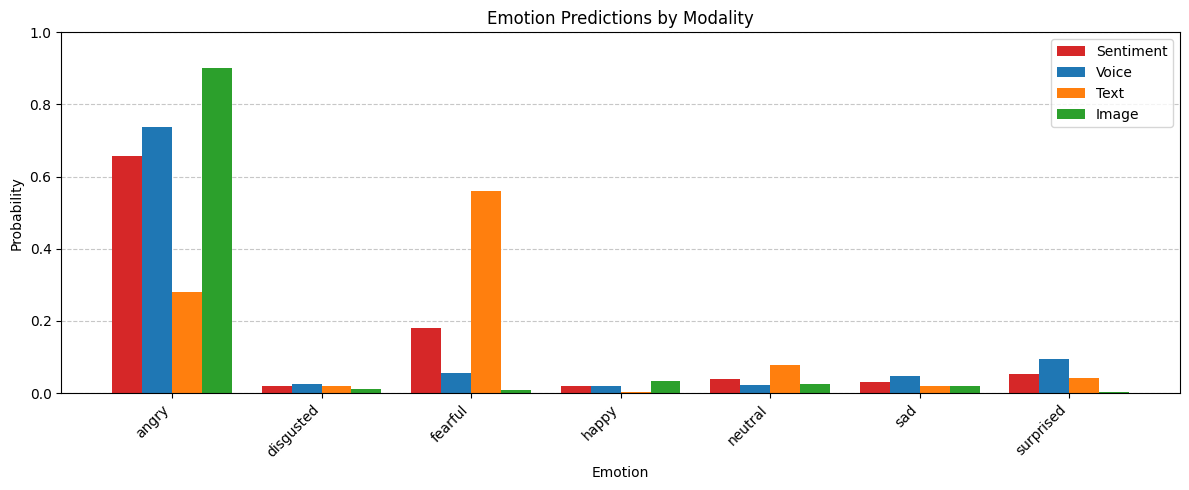

In [ ]:
sentiment_array = sentiment_combiner(transcription, text_array, image_array, voice_array)
sentiment = {emotional_labels[i]: sentiment_array[i] for i in range(len(emotional_labels))}
print(sentiment)

combined_fig = plot_combined_emotions(voice_array, text_array, image_array, sentiment_array, emotional_labels)
combined_fig.show()